# Data Ingestion

In [3]:
import dask.dataframe as dd


df = dd.read_csv(
    "/kaggle/input/nyc-yellow-taxi-trip-data/yellow_tripdata_2016-*.csv",
    assume_missing=True,
    parse_dates=["tpep_pickup_datetime", "tpep_dropoff_datetime"]
)

print(df.dtypes)  
print(df.head())   


VendorID                         float64
tpep_pickup_datetime      datetime64[ns]
tpep_dropoff_datetime     datetime64[ns]
passenger_count                  float64
trip_distance                    float64
pickup_longitude                 float64
pickup_latitude                  float64
RatecodeID                       float64
store_and_fwd_flag       string[pyarrow]
dropoff_longitude                float64
dropoff_latitude                 float64
payment_type                     float64
fare_amount                      float64
extra                            float64
mta_tax                          float64
tip_amount                       float64
tolls_amount                     float64
improvement_surcharge            float64
total_amount                     float64
dtype: object
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       2.0           2016-01-01            2016-01-01              2.0   
1       2.0           2016-01-01            2016-01-01   

# Data Storage

In [4]:
df.to_parquet(
    "/kaggle/working/nyc_taxi_raw.parquet",
    engine="pyarrow",
    compression="snappy"
)

In [5]:
import shutil

shutil.make_archive("/kaggle/working/nyc_taxi_raw", 'zip', "/kaggle/working/nyc_taxi_raw.parquet")

print("✅ Zipped parquet saved at: /kaggle/working/nyc_taxi_raw.zip")


✅ Zipped parquet saved at: /kaggle/working/nyc_taxi_raw.zip


In [6]:
import dask.dataframe as dd

df = dd.read_parquet(
    "/kaggle/input/nyc-yellow-taxi-raw-parquet-20152016/*.parquet",
    engine="pyarrow"
)

print(df.shape)
print(df.head())


(<dask_expr.expr.Scalar: expr=ReadParquetFSSpec(a300617).size() // 19, dtype=int64>, 19)
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       2.0           2016-01-01            2016-01-01              2.0   
1       2.0           2016-01-01            2016-01-01              5.0   
2       2.0           2016-01-01            2016-01-01              1.0   
3       2.0           2016-01-01            2016-01-01              1.0   
4       2.0           2016-01-01            2016-01-01              3.0   

   trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
0           1.10        -73.990372        40.734695         1.0   
1           4.90        -73.980782        40.729912         1.0   
2          10.54        -73.984550        40.679565         1.0   
3           4.75        -73.993469        40.718990         1.0   
4           1.76        -73.960625        40.781330         1.0   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude

# Data Processing

In [7]:
# Drop irrelevant columns

cols_to_drop = ["VendorID", "store_and_fwd_flag"]
df = df.drop(columns=cols_to_drop, errors="ignore")

In [8]:
#Handle missing values

df = df.dropna(
    subset=["tpep_pickup_datetime", "tpep_dropoff_datetime", "fare_amount", "trip_distance"]
)

In [9]:
#Remove invalid trips

df["trip_duration"] = (
    df["tpep_dropoff_datetime"] - df["tpep_pickup_datetime"]
).dt.total_seconds() / 60

In [10]:
# Apply filters
df = df[
    (df["fare_amount"] > 0) &
    (df["trip_distance"] > 0) &
    (df["trip_duration"] > 0) &
    (df["trip_distance"] < 200)
]

In [11]:
# Feature engineering

# Average speed in mph
df["avg_speed"] = df["trip_distance"] / (df["trip_duration"] / 60)

In [12]:
# Tip percentage
df["tip_pct"] = df["tip_amount"] / df["fare_amount"]

In [13]:
# Time-based features
df["pickup_hour"] = df["tpep_pickup_datetime"].dt.hour
df["pickup_day_of_week"] = df["tpep_pickup_datetime"].dt.dayofweek
df["is_weekend"] = df["pickup_day_of_week"] >= 5

In [14]:
#Save processed dataset

df.to_parquet(
    "/kaggle/working/nyc_taxi_processed.parquet",
    engine="pyarrow",
    compression="snappy"
)

print("✅ Processing complete. Saved to /kaggle/working/nyc_taxi_processed.parquet")

✅ Processing complete. Saved to /kaggle/working/nyc_taxi_processed.parquet


In [15]:
import shutil
shutil.make_archive("/kaggle/working/nyc_taxi_processed", 'zip', "/kaggle/working/nyc_taxi_processed.parquet")


'/kaggle/working/nyc_taxi_processed.zip'

In [18]:
print(df.columns)

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_duration', 'avg_speed',
       'tip_pct', 'pickup_hour', 'pickup_day_of_week', 'is_weekend'],
      dtype='object')


In [19]:
# Sample small fraction for visualization (avoid memory overload)
sample = df.sample(frac=0.001).compute()

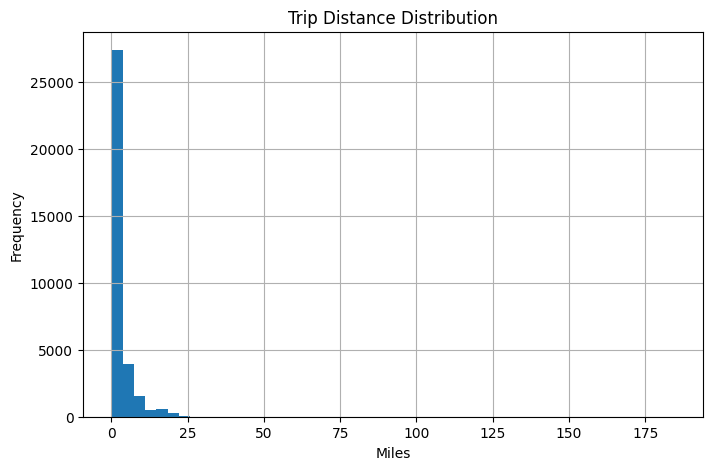

In [20]:
import matplotlib.pyplot as plt

# Plot 1: Trip distance distribution
plt.figure(figsize=(8,5))
sample["trip_distance"].hist(bins=50)
plt.title("Trip Distance Distribution")
plt.xlabel("Miles")
plt.ylabel("Frequency")
plt.show()

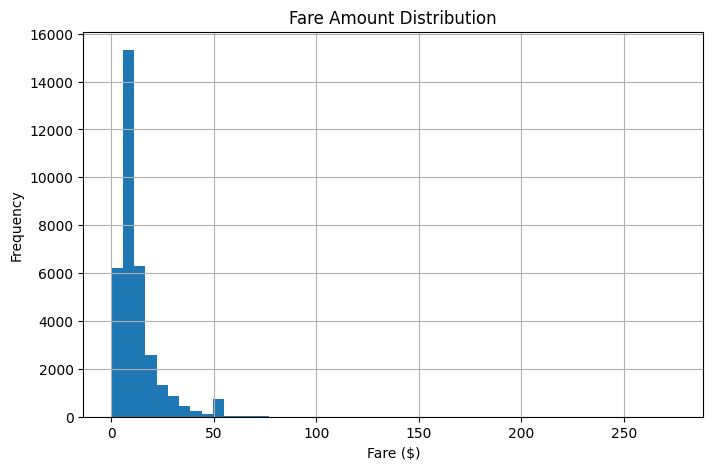

In [21]:
# Plot 2: Fare amount distribution
plt.figure(figsize=(8,5))
sample["fare_amount"].hist(bins=50)
plt.title("Fare Amount Distribution")
plt.xlabel("Fare ($)")
plt.ylabel("Frequency")
plt.show()

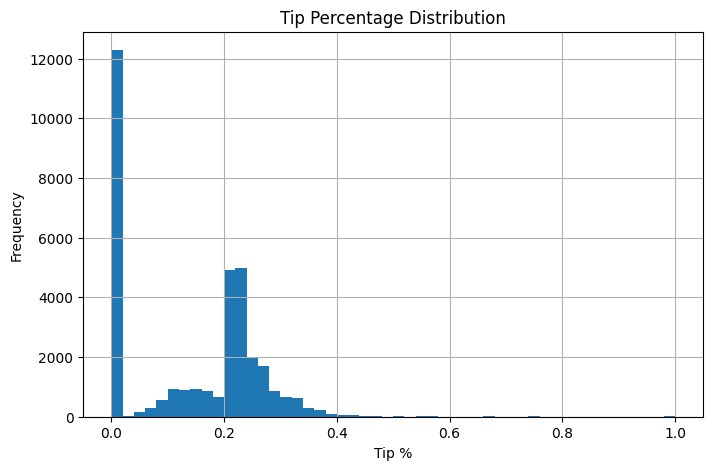

In [22]:
# Plot 3: Tip percentage distribution
plt.figure(figsize=(8,5))
sample["tip_pct"].clip(0,1).hist(bins=50)  # clip to 100% tips
plt.title("Tip Percentage Distribution")
plt.xlabel("Tip %")
plt.ylabel("Frequency")
plt.show()

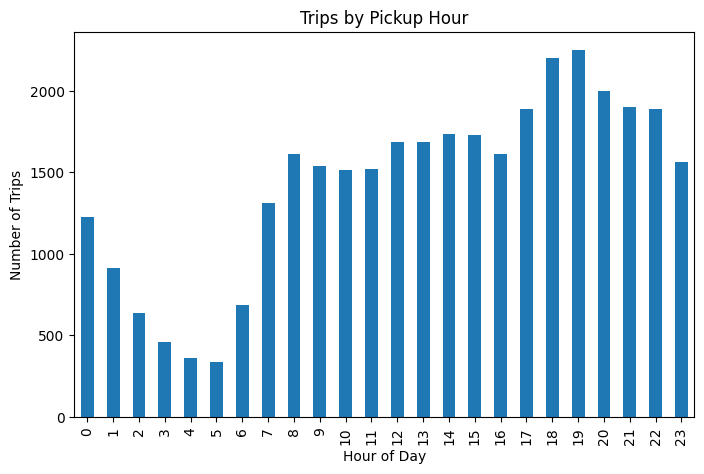

In [23]:
# Plot 4: Trips by pickup hour
plt.figure(figsize=(8,5))
sample["pickup_hour"].value_counts().sort_index().plot(kind="bar")
plt.title("Trips by Pickup Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trips")
plt.show()

# Machine Learning & Analytics

## Regression Task (Fare Prediction)

In [24]:
import dask.dataframe as dd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

In [25]:
# Load processed dataset

df = dd.read_parquet(
    "/kaggle/working/nyc_taxi_processed.parquet",
    engine="pyarrow"
)

print("✅ Processed data loaded")
print("Shape:", df.shape)
print(df.columns)

✅ Processed data loaded
Shape: (<dask_expr.expr.Scalar: expr=ReadParquetFSSpec(46783f2).size() // 23, dtype=int64>, 23)
Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_duration', 'avg_speed',
       'tip_pct', 'pickup_hour', 'pickup_day_of_week', 'is_weekend'],
      dtype='object')


In [26]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RatecodeID',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'trip_duration', 'avg_speed',
       'tip_pct', 'pickup_hour', 'pickup_day_of_week', 'is_weekend'],
      dtype='object')

In [27]:
#Select features & target

features = [
    "trip_distance",
    "passenger_count",
    "trip_duration",
    "pickup_hour",
    "pickup_day_of_week",
    "is_weekend"
]
target = "fare_amount"

df_ml = df[features + [target]]

In [28]:
#. Sample data 

df_sample = df_ml.sample(frac=0.01, random_state=42).compute()  # 1% sample
print("Sample shape:", df_sample.shape)
print(df_sample.head())


Sample shape: (342796, 7)
        trip_distance  passenger_count  trip_duration  pickup_hour  \
121488           2.24              6.0      10.233333           16   
266324           6.80              1.0      18.483333           13   
411231           9.83              1.0      43.033333           17   
405240           8.90              1.0      18.883333           21   
109182           2.01              2.0      23.050000           20   

        pickup_day_of_week  is_weekend  fare_amount  
121488                   5        True          9.5  
266324                   1       False         22.0  
411231                   5        True         35.0  
405240                   1       False         26.0  
109182                   4       False         15.0  


In [29]:
# Train-test split

X = df_sample[features]
y = df_sample[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [30]:
## (a) Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [66]:
# (b) Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [32]:
def eval_model(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} → RMSE: {rmse:.2f}, MAE: {mae:.2f}")

In [33]:
eval_model(y_test, y_pred_lr, "Linear Regression")
eval_model(y_test, y_pred_rf, "Random Forest Regressor")

Linear Regression → RMSE: 3.18, MAE: 1.67
Random Forest Regressor → RMSE: 2.76, MAE: 0.54


## Classification

In [34]:
import dask.dataframe as dd
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [35]:
 #Load processed dataset
# -----------------------------
df = dd.read_parquet(
    "/kaggle/working/nyc_taxi_processed.parquet",  # or Kaggle dataset path if uploaded
    engine="pyarrow"
)

In [36]:
print("✅ Processed data loaded")
print(df.shape)

✅ Processed data loaded
(<dask_expr.expr.Scalar: expr=ReadParquetFSSpec(46783f2).size() // 23, dtype=int64>, 23)


In [37]:
df["is_high_tip"] = (df["tip_pct"] > 0.2).astype(int)

In [38]:
features = [
    "trip_distance",
    "passenger_count",
    "trip_duration",
    "pickup_hour",
    "pickup_day_of_week",
    "is_weekend",
    "payment_type"
]
target = "is_high_tip"

df_clf = df[features + [target]]

In [39]:
df_sample = df_clf.sample(frac=0.01, random_state=42).compute()
print("Sample shape:", df_sample.shape)
print(df_sample.head())

Sample shape: (342794, 8)
        trip_distance  passenger_count  trip_duration  pickup_hour  \
169975            0.8              1.0       6.816667           12   
281788            4.1              1.0      17.600000            3   
366080            2.7              1.0       5.900000            6   
301744           10.0              1.0      18.750000            7   
327138            2.0              1.0       5.966667            4   

        pickup_day_of_week  is_weekend  payment_type  is_high_tip  
169975                   5        True           1.0            0  
281788                   6        True           2.0            0  
366080                   3       False           2.0            0  
301744                   6        True           1.0            1  
327138                   6        True           1.0            0  


In [40]:
#Train-test split
# -----------------------------
X = df_sample[features]
y = df_sample[target]

In [41]:
# Handle categorical: convert payment_type to numeric
X = pd.get_dummies(X, columns=["payment_type"], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [42]:
#Train Models


## Logistic Regression (baseline)
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:,1]

In [43]:
## Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:,1]

In [46]:
def eval_clf(y_true, y_pred, y_prob, name):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    print(f"{name} → Acc: {acc:.3f}, Prec: {prec:.3f}, Rec: {rec:.3f}, F1: {f1:.3f}, ROC-AUC: {roc:.3f}")


In [47]:
#Report Results
# -----------------------------
eval_clf(y_test, y_pred_lr, y_prob_lr, "Logistic Regression")
eval_clf(y_test, y_pred_rf, y_prob_rf, "Random Forest Classifier")

Logistic Regression → Acc: 0.813, Prec: 0.720, Rec: 0.999, F1: 0.837, ROC-AUC: 0.838
Random Forest Classifier → Acc: 0.780, Prec: 0.725, Rec: 0.871, F1: 0.792, ROC-AUC: 0.834


### Confusion Matrix & ROC Curve for Classification

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve

In [49]:
#Confusion Matrix Function
# -----------------------------
def plot_conf_matrix(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{name} - Confusion Matrix")
    plt.colorbar()
    classes = ["Low Tip", "High Tip"]
    tick_marks = range(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Labels
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [50]:
# ROC Curve Function
# -----------------------------
def plot_roc(y_true, y_prob_lr, y_prob_rf):
    fpr_lr, tpr_lr, _ = roc_curve(y_true, y_prob_lr)
    fpr_rf, tpr_rf, _ = roc_curve(y_true, y_prob_rf)

    plt.figure(figsize=(6,5))
    plt.plot(fpr_lr, tpr_lr, label="Logistic Regression")
    plt.plot(fpr_rf, tpr_rf, label="Random Forest")
    plt.plot([0,1], [0,1], "k--")
    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

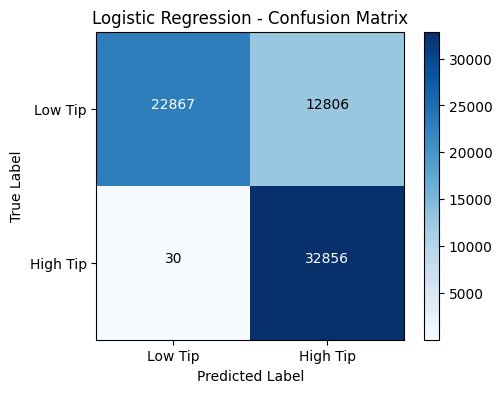

In [52]:
plot_conf_matrix(y_test, y_pred_lr, "Logistic Regression")

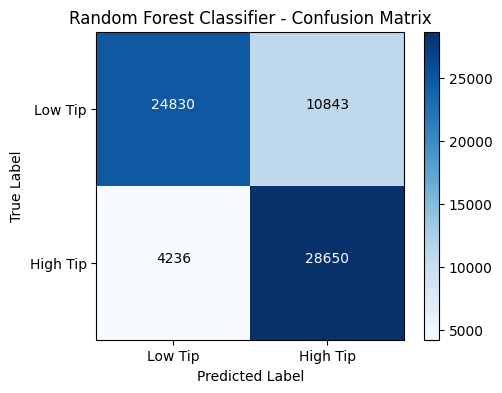

In [53]:
plot_conf_matrix(y_test, y_pred_rf, "Random Forest Classifier")

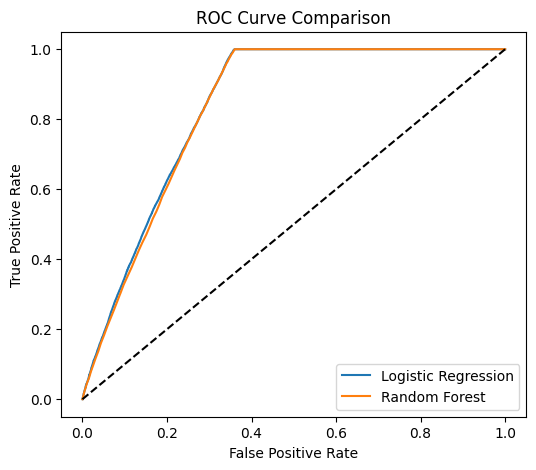

In [54]:
plot_roc(y_test, y_prob_lr, y_prob_rf)

In [67]:
import joblib

# Save best regression model
joblib.dump(rf, "best_fare_model.pkl")

# Save best classification model
joblib.dump(log_reg, "best_tip_model.pkl")

print("✅ Saved: best_fare_model.pkl and best_tip_model.pkl")


✅ Saved: best_fare_model.pkl and best_tip_model.pkl


In [68]:
import shutil

# Zip the models for download
shutil.make_archive("/kaggle/working/taxi_best_models", 'zip', "/kaggle/working")

print("✅ Models zipped at /kaggle/working/taxi_best_models.zip")


✅ Models zipped at /kaggle/working/taxi_best_models.zip
